# Milestone 1: Exploration Phase

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from aux_functions import plot_curves
from pathlib import Path

In [8]:
CSV_PATH = Path.cwd().parents[2].joinpath("zrive-data", "feature_frame.csv")

In [9]:
df = pd.read_csv(CSV_PATH)

In [4]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [10]:
information_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
target_col = "outcome"
feature_cols = [col for col in df.columns if col not in information_cols + [target_col]]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

## 1st task: filter the data to only those orders with 5 items or more to build a dataset to work with.

In [11]:
# Sum outcome (A product is in the order if its outcome is 1)
count_products = df.groupby("order_id").outcome.sum().reset_index()
count_products.head()

,order_id,outcome
0,2807985930372,9.0
1,2808027644036,6.0
2,2808099078276,9.0
3,2808393957508,13.0
4,2808429314180,3.0


In [12]:
filtered_orders = count_products[count_products.outcome >= 5]

In [13]:
filtered_df = df[df["order_id"].isin(filtered_orders["order_id"])]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      float64

## 2nd task: Split data into training, validation and test

In [10]:
filtered_df.shape

(2163953, 27)

In [15]:
filtered_df.groupby("order_id").outcome.sum().reset_index().shape

(2603, 2)

There are 2163953 products spread over 2603 orders. In my opinion, a good approach could be a temporary-based split (in order to prevent from infomation leakage), using a typical 70/20/10 distribution.

In [14]:
# Get how many orders are performed each day
daily_orders = filtered_df.groupby("order_date").order_id.nunique()
daily_orders.head()

order_date
2020-10-05 00:00:00     3
2020-10-06 00:00:00     7
2020-10-07 00:00:00     6
2020-10-08 00:00:00    12
2020-10-09 00:00:00     4
Name: order_id, dtype: int64

In [15]:
total_orders = daily_orders.sum()
percentage_orders = pd.DataFrame(columns=["date", "percentage"])
rows = []
number_orders = 0
for _, row in daily_orders.reset_index().iterrows():
    date = row.iloc[0]
    number_orders += row.iloc[1]
    rows.append(
        {"date": date, "percentage": number_orders / total_orders}
    )
percentage_orders = pd.DataFrame(rows)

print(percentage_orders.head())

train_val_cut = percentage_orders[percentage_orders.percentage <= 0.7].iloc[-1]
val_test_cut = percentage_orders[percentage_orders.percentage <= 0.9].iloc[-1]

print(f"Train set from: {daily_orders.index.min()}")
print(f"Train set to: {train_val_cut.date}")
print(f"Validation set from: {train_val_cut.date}")
print(f"Validation set to: {val_test_cut.date}")
print(f"Test set from: {val_test_cut.date}")
print(f"Test set to: {daily_orders.index.max()}")


                  date  percentage
0  2020-10-05 00:00:00    0.001153
1  2020-10-06 00:00:00    0.003842
2  2020-10-07 00:00:00    0.006147
3  2020-10-08 00:00:00    0.010757
4  2020-10-09 00:00:00    0.012294
Train set from: 2020-10-05 00:00:00
Train set to: 2021-02-04 00:00:00
Validation set from: 2021-02-04 00:00:00
Validation set to: 2021-02-22 00:00:00
Test set from: 2021-02-22 00:00:00
Test set to: 2021-03-03 00:00:00


With the dates to split the data selected, is time to create the actual datasets

In [16]:
train_set = filtered_df[filtered_df.order_date <= train_val_cut.date]
val_set = filtered_df[(filtered_df.order_date > train_val_cut.date) & (filtered_df.order_date <= val_test_cut.date)]
test_set = filtered_df[filtered_df.order_date > val_test_cut.date]

Divide dataset into features and target

In [17]:
x_train = train_set[feature_cols]
y_train = train_set[target_col]

x_val = val_set[feature_cols]
y_val = val_set[target_col]

x_test = test_set[feature_cols]
y_test = test_set[target_col]

## 3rd task: Define a baseline

In order to have something with which compare our model, we need a baseline. Sometimes it could be given by a business metric or a previous metric. Due to in this we do not have anything of that, we need to define one. I will simply use the "global_popularity" feature as it. This means that the product will be predicted to be bought the more popular it is.

/tmp/ipykernel_1437/3314613440.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


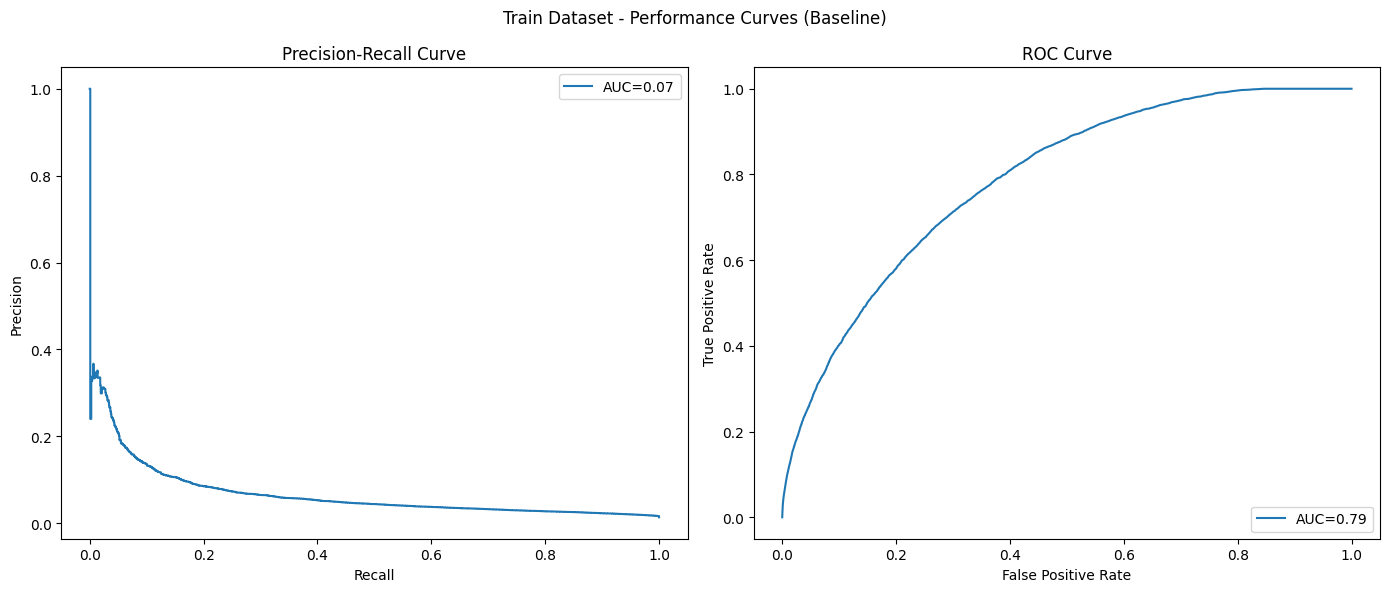

In [18]:
y_pred = val_set["global_popularity"]
y_true = val_set["outcome"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"Train Dataset - Performance Curves (Baseline)")

plot_curves(ax, y_true, y_pred, curve_type="both")

ax[0].legend(loc="upper right")
ax[1].legend(loc="lower right")
ax[0].legend(loc="upper right")
ax[1].legend(loc="lower right")

plt.tight_layout()
fig.show()


## 4th task: Train and evaluate a first model

I will start using a model with just numeric and binary variables, as they don"t need preprocessing. Then, I can compare it with models that include all the variables. Due to the problem is a binary classification I will use Logistic Regression (lineal model)

In [19]:
train_cols = numerical_cols + binary_cols

In [20]:
# First, standardize the data
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train[train_cols])
x_val_scaled = scaler.transform(x_val[train_cols])

### 4.1 Ridge

/tmp/ipykernel_1437/3663856880.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_train.show()
/tmp/ipykernel_1437/3663856880.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_val.show()


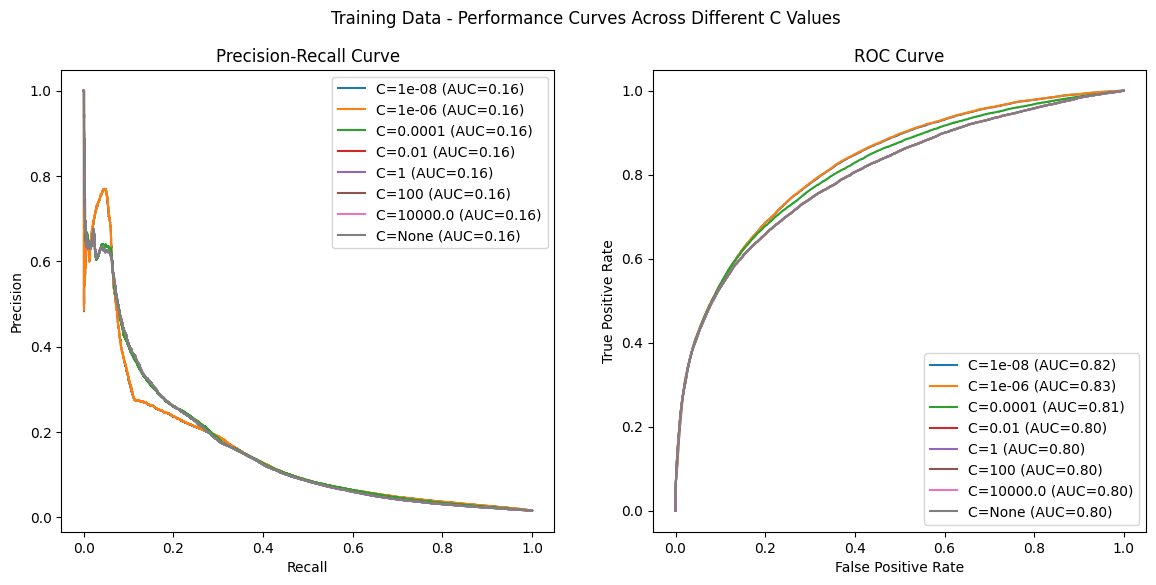

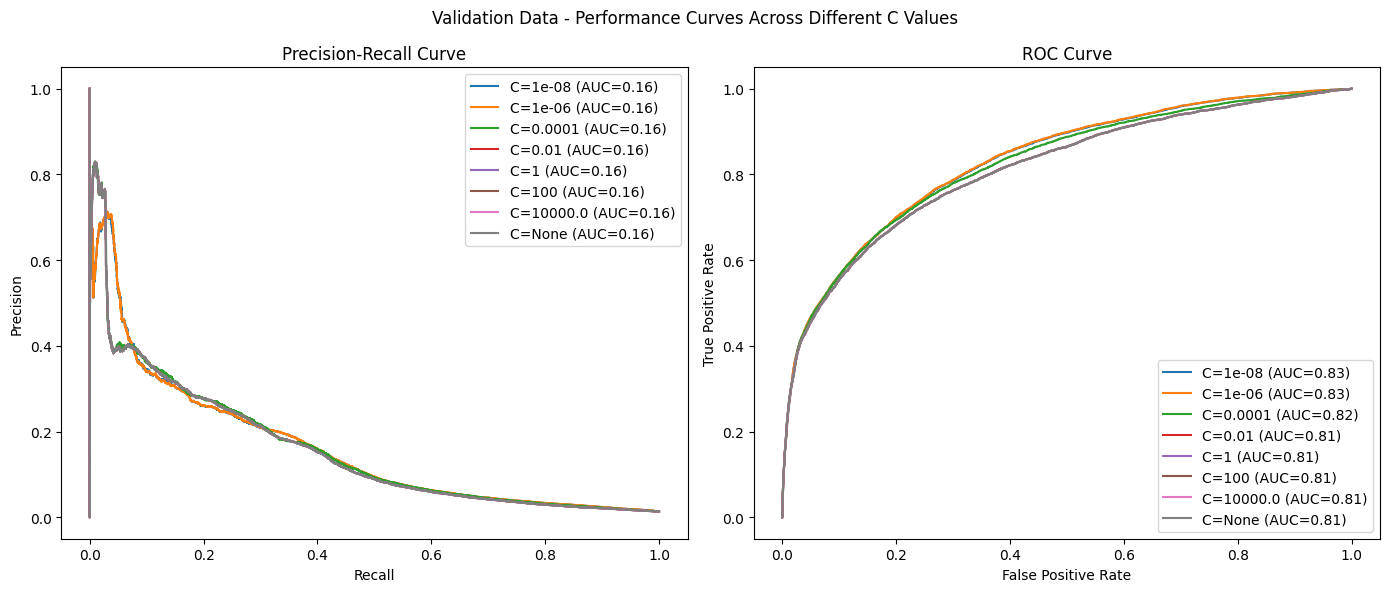

In [21]:
fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 6))
fig_train.suptitle("Training Data - Performance Curves Across Different C Values")
fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 6))
fig_val.suptitle("Validation Data - Performance Curves Across Different C Values")

# Define hyperparameter for the level of regularisation
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]

for c in cs:
    if c == None:
        lr = LogisticRegression(penalty = None)
    else:
        lr = LogisticRegression(penalty="l2", C=c)
    
    lr.fit(x_train_scaled, y_train)

    train_proba = lr.predict_proba(x_train_scaled)[:, 1]
    plot_curves(ax_train, y_train, train_proba, curve_type="both", label=f"C={c}")

    val_proba = lr.predict_proba(x_val_scaled)[:, 1]
    plot_curves(ax_val, y_val, val_proba, curve_type="both", label=f"C={c}")

ax_train[0].legend(loc="upper right")
ax_train[1].legend(loc="lower right")
ax_val[0].legend(loc="upper right")
ax_val[1].legend(loc="lower right")

plt.tight_layout()
fig_train.show()
fig_val.show()

The graphs show that regularisation does not improve the model’s performance. Both the ROC and precision-recall curves, along with their AUC values, remain consistent across different regularisation strengths. This suggests the model's complexity is already suitable for the task, and further adjustments are unnecessary.

Additionally, the dataset is highly imbalanced, with a majority of negative examples. This imbalance affects the False Positive Rate (FPR), which appears low despite a significant number of false positives. However, the precision-recall curves provide a clearer picture, showing improvements over the baseline.

Lastly, similar error rates between the training and validation datasets suggest effective generalisation, indicating the model is not overfitting but learning from the data.

### 4.2 Lasso
(Same code as Ridge just changing the parameter of LogisticRegression, pending abstract into a separated function)

/tmp/ipykernel_1437/4173363900.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_train.show()
/tmp/ipykernel_1437/4173363900.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_val.show()


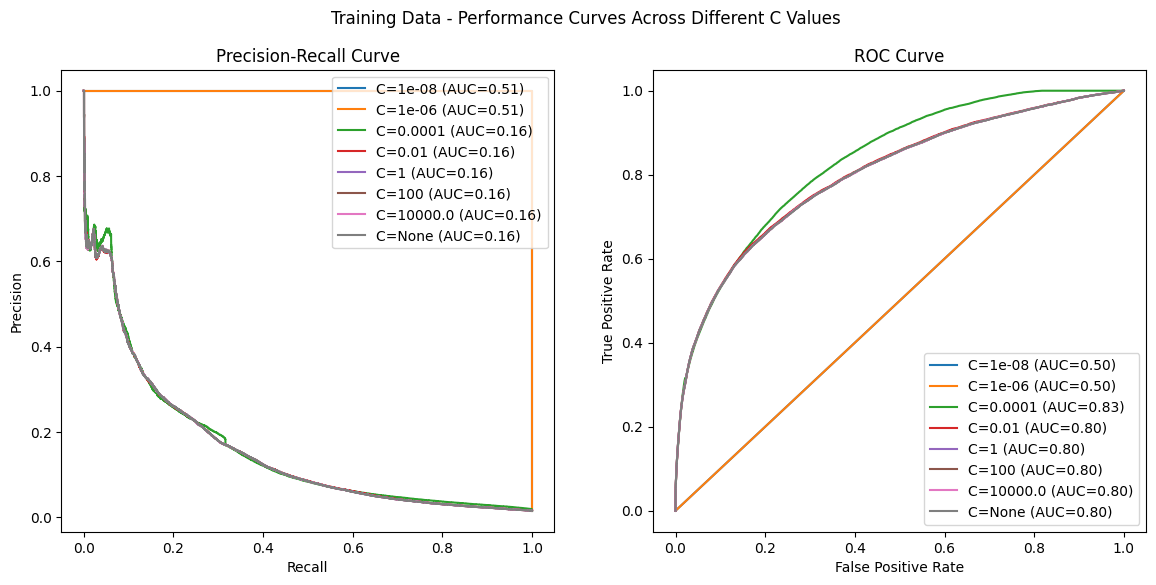

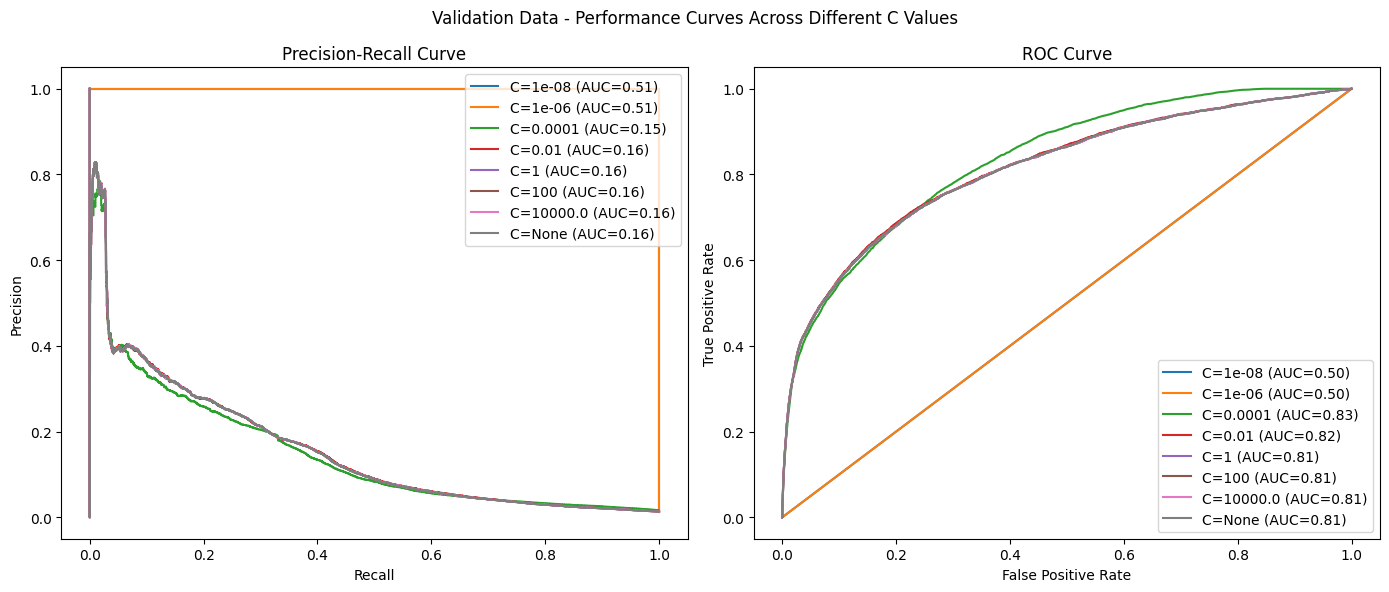

In [23]:
fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 6))
fig_train.suptitle("Training Data - Performance Curves Across Different C Values")
fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 6))
fig_val.suptitle("Validation Data - Performance Curves Across Different C Values")

# Define hyperparameter for the level of regularisation
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]

for c in cs:
    if c == None:
        lr = LogisticRegression(penalty = None)
    else:
        lr = LogisticRegression(penalty="l1", C=c, solver="saga")
    
    lr.fit(x_train_scaled, y_train)

    train_proba = lr.predict_proba(x_train_scaled)[:, 1]
    plot_curves(ax_train, y_train, train_proba, curve_type="both", label=f"C={c}")

    val_proba = lr.predict_proba(x_val_scaled)[:, 1]
    plot_curves(ax_val, y_val, val_proba, curve_type="both", label=f"C={c}")

ax_train[0].legend(loc="upper right")
ax_train[1].legend(loc="lower right")
ax_val[0].legend(loc="upper right")
ax_val[1].legend(loc="lower right")

plt.tight_layout()
fig_train.show()
fig_val.show()